# *Energy Consumption Time Series Forecasting*

<p style='font-size:20px;'><i>The objective of this task is to forecast short-term household energy usage using historical time-based patterns. We will parse and resample the time series data, engineer time-based features and train models like ARIMA, Prophet and XGBoost to forecast the energy consumption.</i></p>

## *Data Cleaning and Preprocessing*

In [56]:
# Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('household_power_consumption.csv')

In [4]:
# Display the first five rows to get a quick preview
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [5]:
# Get the number of rows and columns of the dataset
df.shape

(1048575, 9)

In [6]:
# Display concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  object 
 1   Time                   1048575 non-null  object 
 2   Global_active_power    1048575 non-null  object 
 3   Global_reactive_power  1048575 non-null  object 
 4   Voltage                1048575 non-null  object 
 5   Global_intensity       1048575 non-null  object 
 6   Sub_metering_1         1048575 non-null  object 
 7   Sub_metering_2         1048575 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(8)
memory usage: 72.0+ MB


In [7]:
# Check for null values
df.isnull().sum()

Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           4069
dtype: int64

In [8]:
# Check for duplicate rows
df.duplicated().sum()

0

### *Parsing and Resampling Time Series Data*

In [9]:
# Convert 'Date' and 'Time' columns to a datetime object and create a new DateTime column 
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format= "%d/%m/%Y %H:%M:%S")
# Set the 'DateTime' column as the dataframe index for time series analysis
df.set_index('DateTime', inplace=True)

In [10]:
# Convert Global_active_power from object to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
# Resample to daily average 
df_resampled = df['Global_active_power'].resample('d').mean().ffill()

In [11]:
# Display the new resampled time series
df_resampled

DateTime
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
                ...   
2008-12-09    1.391072
2008-12-10    1.540891
2008-12-11    0.994807
2008-12-12    1.260787
2008-12-13    1.354373
Freq: D, Name: Global_active_power, Length: 729, dtype: float64

In [12]:
# Display information about the resampled time series
df_resampled.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 729 entries, 2006-12-16 to 2008-12-13
Freq: D
Series name: Global_active_power
Non-Null Count  Dtype  
--------------  -----  
729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


## *Feature Engineering*

In [13]:
# Convert the resampled time series to a dataframe
df_features = df_resampled.to_frame(name='power')

# Create lagged features for time series forecasting
for lag in [1, 2, 3, 7, 14]:
    df_features[f'lag_{lag}'] = df_features['power'].shift(lag)

# Calculate 7-day rolling statistics
df_features['rolling_mean_7'] = df_features['power'].rolling(window=7).mean() # Rolling mean captures the trend component
df_features['rolling_std_7'] = df_features['power'].rolling(window=7).std()   # Rolling std captures the volatility

# Calculate 30-day rolling statistics for longer-term patterns
df_features['rolling_mean_30'] = df_features['power'].rolling(window=30).mean()
df_features['rolling_std_30'] = df_features['power'].rolling(window=30).std()

# Extract time-based features from the datetime index
df_features['day_of_week'] = df_features.index.dayofweek
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_features['month'] = df_features.index.month
df_features['quarter'] = df_features.index.quarter
df_features['year'] = df_features.index.year

In [14]:
# Drop rows with any missing values 
df_features = df_features.dropna()
# Display the features dataframe
df_features

,power,lag_1,lag_2,lag_3,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day_of_week,is_weekend,month,quarter,year
DateTime,,,,,,,,,,,,,,,
2007-01-14,2.090213,2.213065,1.014789,1.566107,1.699736,2.426525,1.605002,0.421003,1.762659,0.626866,6,1,1,1,2007
2007-01-15,1.492137,2.090213,2.213065,1.014789,1.556500,1.909031,1.595808,0.422937,1.710614,0.578988,0,0,1,1,2007
2007-01-16,1.171114,1.492137,2.090213,2.213065,1.297954,0.881414,1.577688,0.440191,1.671169,0.573898,1,0,1,1,2007
2007-01-17,1.977561,1.171114,1.492137,2.090213,1.496389,0.704204,1.646427,0.462389,1.686073,0.575919,2,0,1,1,2007
2007-01-18,1.264904,1.977561,1.171114,1.492137,1.566107,2.263481,1.603398,0.484591,1.689667,0.572832,3,0,1,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-09,1.391072,1.297664,1.713014,1.752664,1.245447,1.876979,1.430037,0.222625,1.457001,0.364565,1,0,12,4,2008
2008-12-10,1.540891,1.391072,1.297664,1.713014,1.218864,1.052746,1.476041,0.204227,1.459738,0.364887,2,0,12,4,2008
2008-12-11,0.994807,1.540891,1.391072,1.297664,1.207387,1.640429,1.445672,0.259232,1.436047,0.371392,3,0,12,4,2008


## *Exploratory Data Analysis*

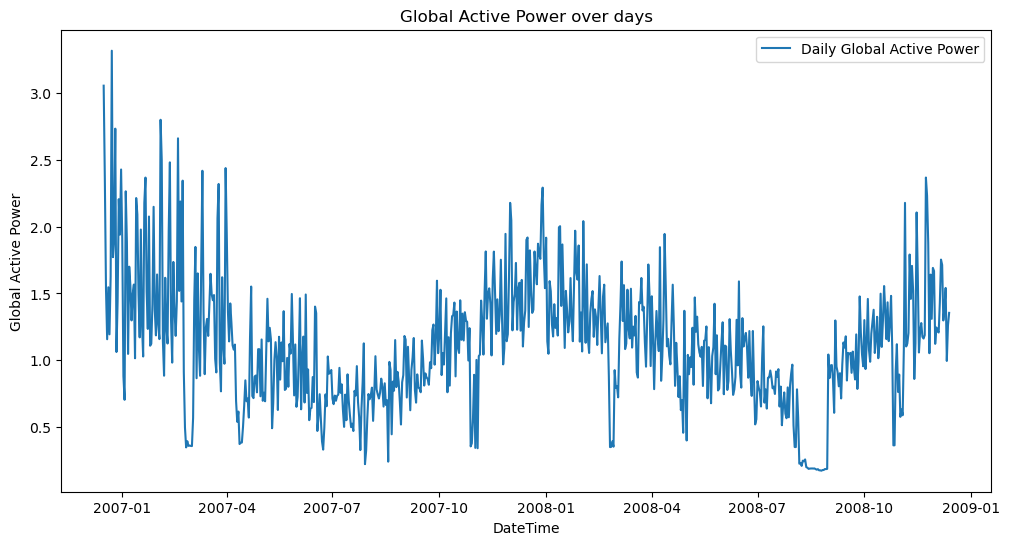

In [15]:
# Plot the resampled time series 
plt.figure(figsize=(12,6))
plt.plot(df_resampled, label='Daily Global Active Power')
plt.title('Global Active Power over days')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

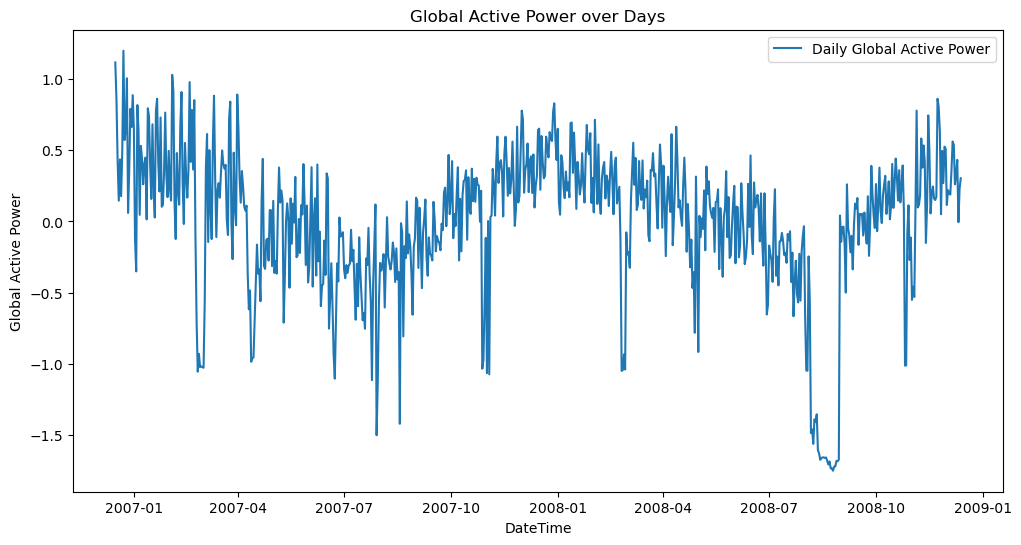

In [16]:
# Plot the logarithmic time series data to reduce skewness and make patterns more visible
df_log = np.log(df_resampled)
plt.figure(figsize=(12,6))
plt.plot(df_log, label='Daily Global Active Power')
plt.title('Global Active Power over Days')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

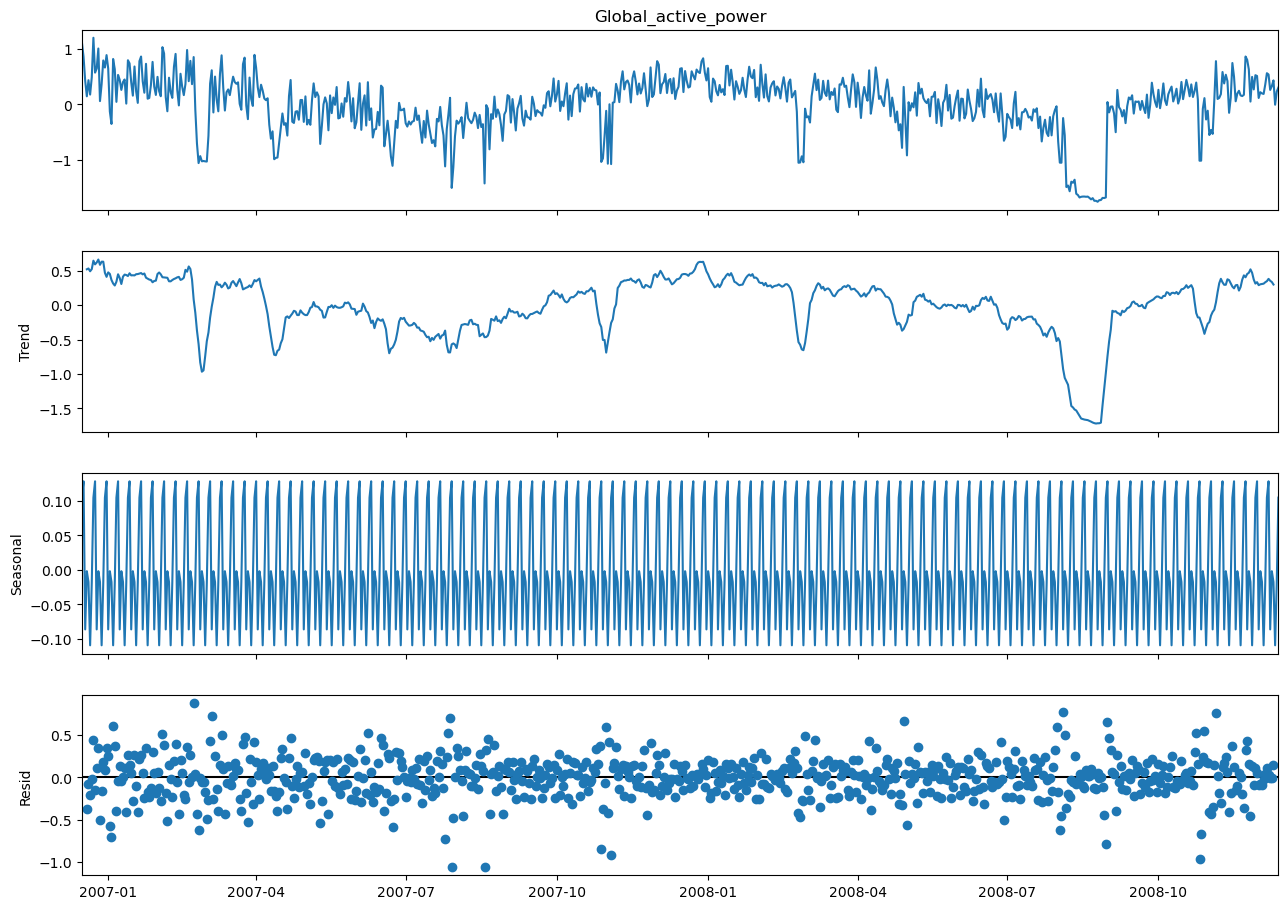

In [17]:
# Using statsmodels' seasonal_decompose function with an additive model to plot the time series into trend, seasonal and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14,10)
plt.show()

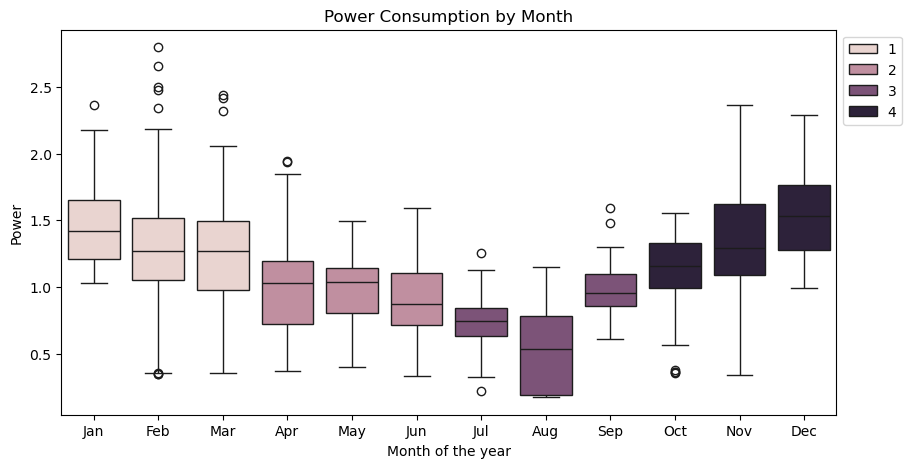

In [18]:
# Create a boxplot showing power consumption by month and quarters of the year
fig,ax = plt.subplots(figsize=(10,5))

month_labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.boxplot(data = df_features,
            x='month',
            y='power',
            hue='quarter',
            ax=ax,
            linewidth=1)

ax.set_title('Power Consumption by Month')
ax.set_xlabel('Month of the year')
# Set the x-tick positions to match the number of month labels
ax.set_xticks(range(len(month_labels)))
# Set the x-tick labels to month names
ax.set_xticklabels(month_labels)
ax.set_ylabel('Power')
# Position the legend outside the plot at the top-right corner
ax.legend(bbox_to_anchor=(1,1))
plt.show()

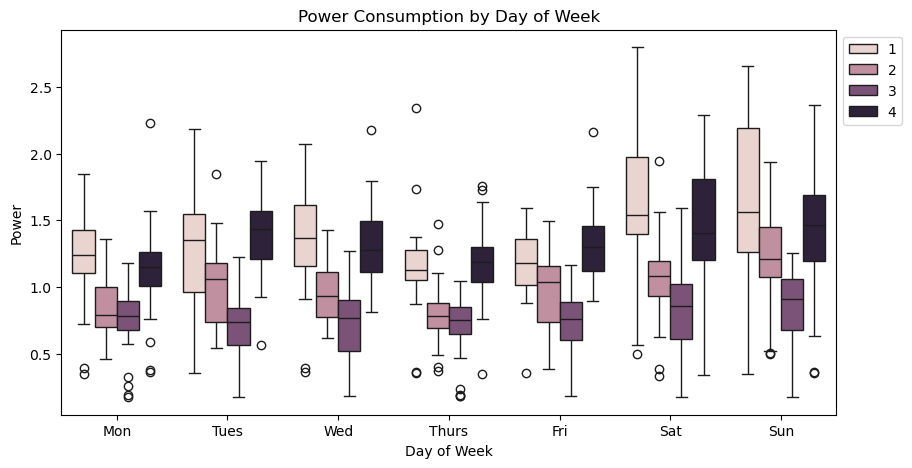

In [19]:
# Create a boxplot showing the power consumption by day of week
fig,ax = plt.subplots(figsize=(10,5))

day_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

sns.boxplot(data = df_features,
            x='day_of_week',
            y='power',
            hue='quarter',
            ax=ax,
            linewidth=1)

ax.set_title('Power Consumption by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_xticks(range(len(day_labels)))
ax.set_xticklabels(day_labels)
ax.set_ylabel('Power')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

## *Checking Stationarity of Data*

In [20]:
# Perform Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_resampled)
# Display the test results
print('ADF Statistics:', adf_test[0])
print('p-value:', adf_test[1])
print('Number of lags:', adf_test[2])
print('Critical values:')
for key, val in adf_test[4].items():
    print('\t',key, ':', val)       # Print each significance level and its critical value

ADF Statistics: -2.752523225010274
p-value: 0.06538201867802927
Number of lags: 20
Critical values:
	 1% : -3.439620010600208
	 5% : -2.8656309041017756
	 10% : -2.5689484851894413


In [21]:
# Calculate the difference between the consecutive rows in the resampled time series
df_resampled1 = df_resampled.diff()

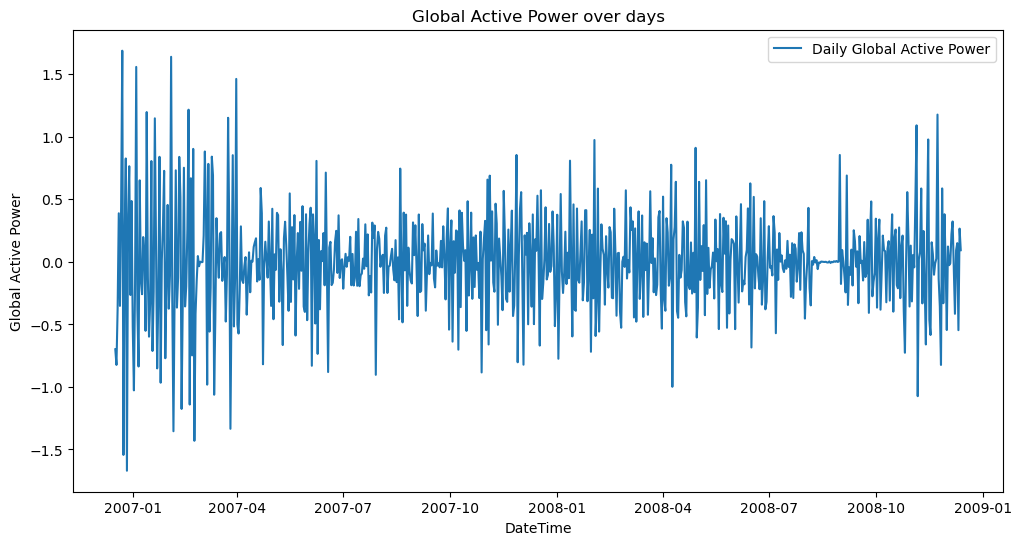

In [22]:
# Plot the differenced time series 
plt.figure(figsize=(12,6))
plt.plot(df_resampled1, label='Daily Global Active Power')
plt.title('Global Active Power over days')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [23]:
# Perform the ADF test again for the differenced time series
adf_test = adfuller(df_resampled1.dropna())
print('ADF Statistics:', adf_test[0])
print('p-value:', adf_test[1])
print('Number of lags:', adf_test[2])
print('Critical values:')
for key, val in adf_test[4].items():
    print('\t',key, ':', val)

ADF Statistics: -8.526375180296732
p-value: 1.0664458073782433e-13
Number of lags: 20
Critical values:
	 1% : -3.439633170421852
	 5% : -2.8656367026715337
	 10% : -2.5689515744354794


## *Splitting Data into Train and Test Sets*

In [24]:
# Split the differenced time series data into train and test sets
train_size = int(len(df_resampled1)*0.8) # 80% train size and 20% test size
train = df_resampled1.iloc[:train_size]
test = df_resampled1.iloc[train_size:]

In [25]:
# Print the ranges and sizes for both train and test time series data
print("Train range:", train.index[0], "to", train.index[-1])
print('Train size:', train.shape)
print("Test range:", test.index[0], "to", test.index[-1])
print('Test size:', test.shape)

Train range: 2006-12-16 00:00:00 to 2008-07-20 00:00:00
Train size: (583,)
Test range: 2008-07-21 00:00:00 to 2008-12-13 00:00:00
Test size: (146,)


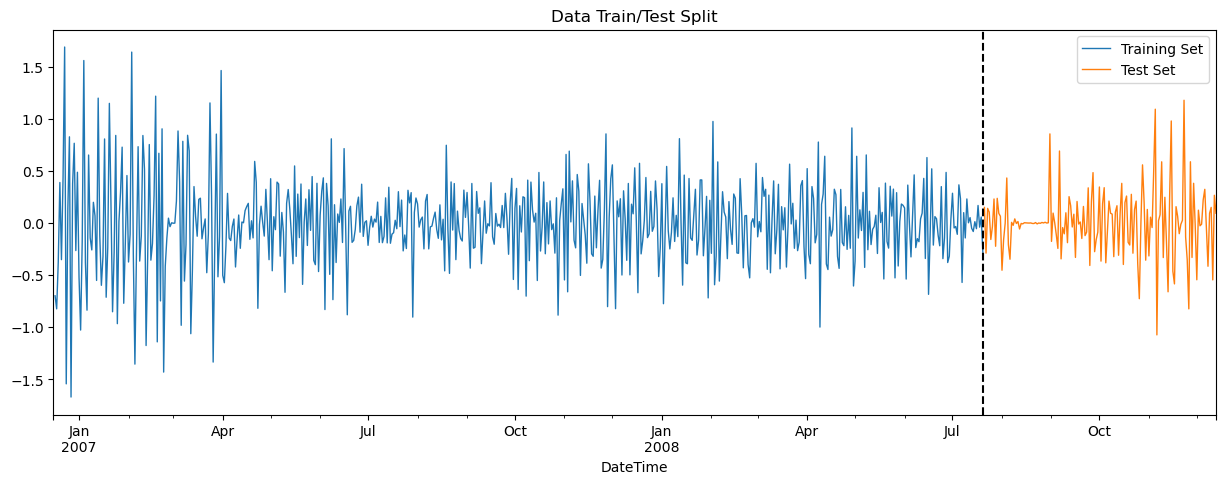

In [26]:
# Visualize the train/test split
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', linewidth=1)
test.plot(ax=ax, label='Test Set', linewidth=1)
ax.axvline(pd.Timestamp(train.index[-1]), color='black', ls='--')
ax.legend()
plt.title('Data Train/Test Split')
plt.show()

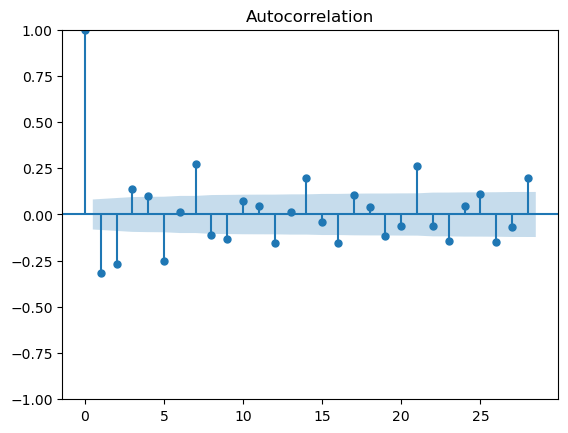

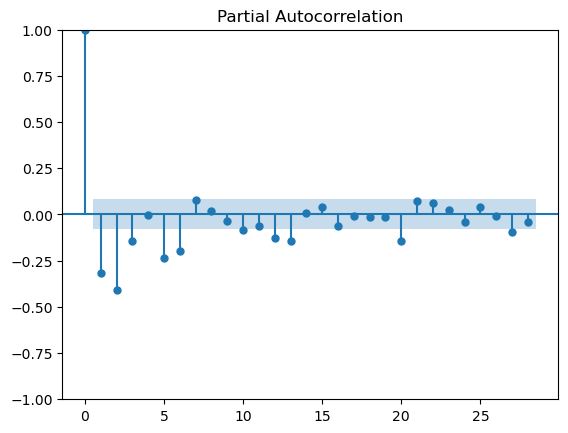

In [27]:
# Plot the autocorrelation and partial autocorrelation function for the training data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Drop the missing values
train=train.dropna()
acf_original = plot_acf(train)
pacf_original = plot_pacf(train)

## *Finding the best ARIMA Model Parameters (p,d,q)*

In [28]:
# Import the itertools module for creating combinations
import itertools
# Define ranges for p, q and d parameters
p=range(0,8)
q=range(0,8)
d=range(0,2)
# Create all possible combinations of p, d, q parameters
pdq_combinations = list(itertools.product(p,d,q))

In [29]:
# Get the total number of possible combinations
len(pdq_combinations)

128

In [30]:
# Initialize empty lists
rmse=[]
order1=[]

In [32]:
# Import ARIMA and evaluation metrics
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Iterate through all the combinations of p, q and d
for pdq in pdq_combinations:
    try:
        # Fit ARIMA model with current parameters on training data
        model=ARIMA(train,order=pdq).fit()
        # Generate forecasts for the test period
        forecast=model.forecast(steps=len(test))
        # Calculate root mean squared error between forecasts and actual test values 
        error=np.sqrt(mean_squared_error(test,forecast))
        # Store the current parameter combinations and its RMSE
        order1.append(pdq)
        rmse.append(error)
    except Exception as e:
        # Handle any errors that occur during model fitting or forecasting
        print(f'Failed for {pdq}: {e}')
        continue

In [33]:
# Create a dataframe for the RMSE results with index being the order (model parameters)
results = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])

In [34]:
# Display the dataframe with RMSE values in ascending order
results.sort_values(by='RMSE')

,RMSE
"(6, 1, 7)",0.316149
"(3, 0, 7)",0.317543
"(4, 1, 7)",0.318063
"(3, 1, 5)",0.318209
"(2, 1, 4)",0.318302
...,...
"(2, 1, 0)",0.343552
"(1, 1, 0)",0.365171
"(1, 1, 0)",0.365171
"(0, 1, 0)",0.431084


## *Training ARIMA Model* 

In [35]:
# Define and fit an ARIMA model using the training data and setting the order parameters with the lowest RMSE
model = ARIMA(train,
             order=(6,1,7),
             )
results = model.fit()

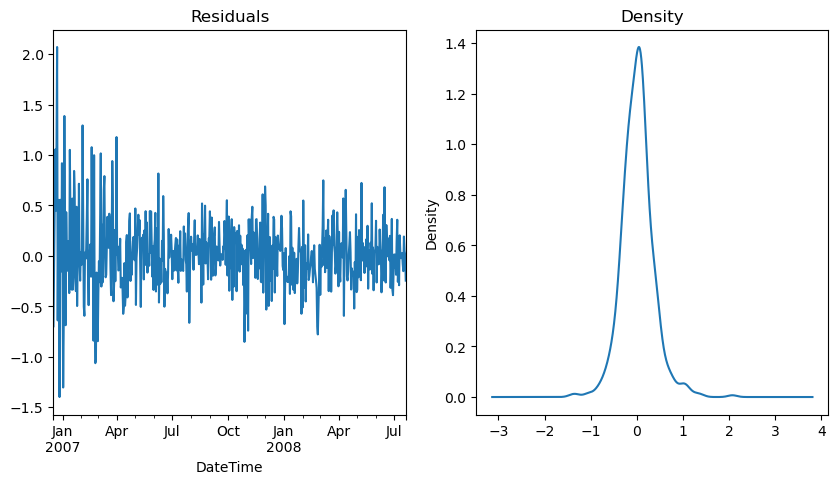

In [36]:
# Extract residuals from the model results
residuals = results.resid
fig, ax = plt.subplots(1,2, figsize=(10,5))
# Plot the residuals over time in the first subplot
residuals.plot(title='Residuals', ax=ax[0])
# Create a kernel density estimation plot of residuals in the second subplot
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

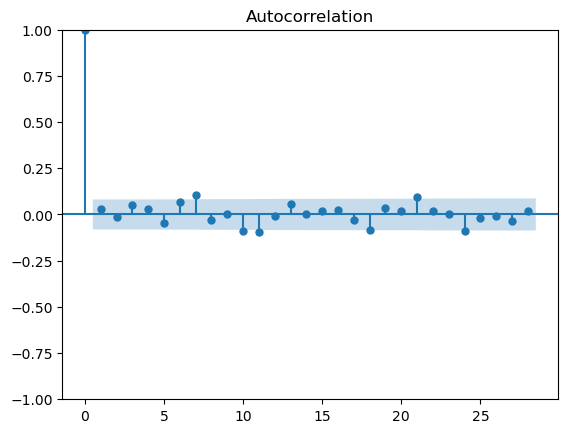

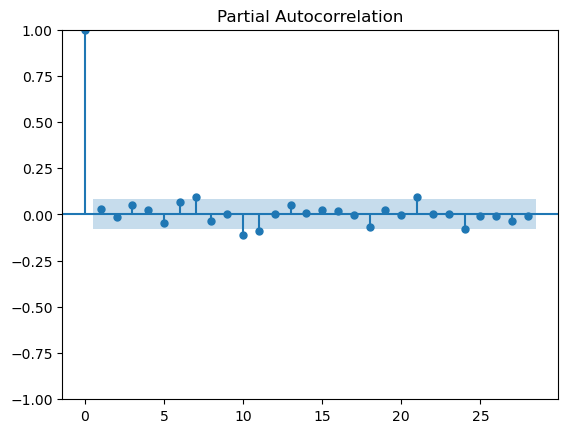

In [37]:
# Plot the autocorrelation and partial autocorrelation functions for the residuals
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

In [38]:
# Forecast the test values using ARIMA
ARIMA_forecast = results.forecast(len(test))

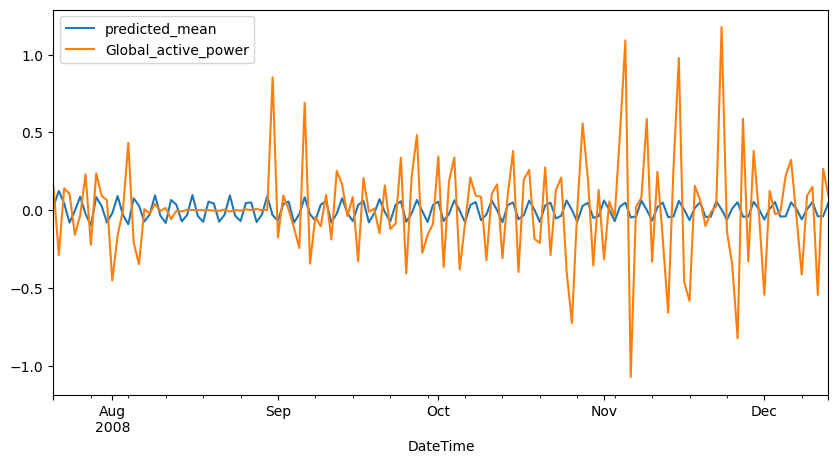

In [39]:
# Plot the forecasted vs test values
plt.figure(figsize=(10,5))
ARIMA_forecast.plot()
test.plot()
plt.legend()
plt.show()

## *Training Prophet Model*

In [40]:
# Import the Prophet model
from prophet import Prophet

# Rename the time series columns to 'ds' and 'y'
prophet_train = train.reset_index().rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})

# Train and fit the Prophet model on the training data
model = Prophet(seasonality_mode='additive')
model.fit(prophet_train)

01:59:27 - cmdstanpy - INFO - Chain [1] start processing
01:59:28 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# Create a dataframe for the future test data to be forecasted
future = model.make_future_dataframe(periods=len(test))

In [42]:
# Forecast the test data using the trained Prophet model
PROPHET_forecast = model.predict(future)

In [43]:
# Include only the yhat values in the dataframe along with the DateTime as index
PROPHET_forecast1 = PROPHET_forecast.set_index('ds')['yhat'].loc[test.index]

In [44]:
# Display the dataframe with the forecasted values 
PROPHET_forecast1

DateTime
2008-07-21   -0.317701
2008-07-22    0.120593
2008-07-23   -0.048115
2008-07-24   -0.073499
2008-07-25    0.111711
                ...   
2008-12-09    0.124185
2008-12-10   -0.044523
2008-12-11   -0.069907
2008-12-12    0.115303
2008-12-13    0.219704
Name: yhat, Length: 146, dtype: float64

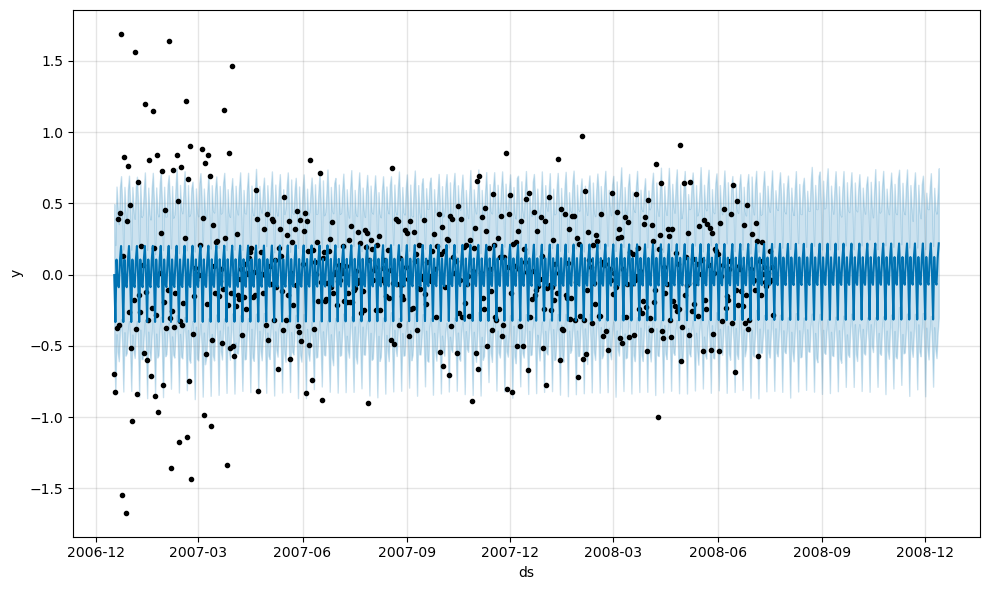

In [45]:
# Plot the forecasted values
model.plot(PROPHET_forecast);

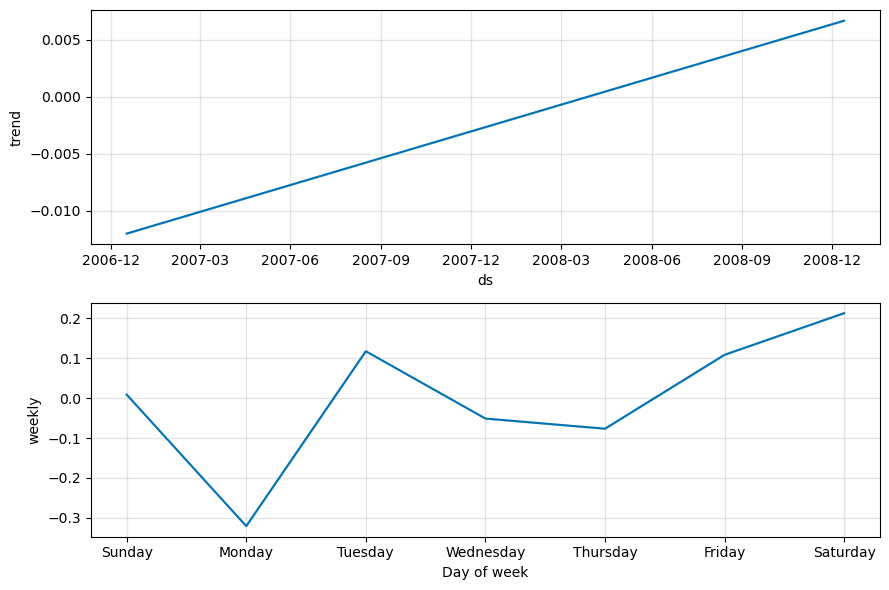

In [46]:
# Plot the components of the forecast
model.plot_components(PROPHET_forecast);

## *Training XGBoost Model*

In [47]:
# Import XBBoost and train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Use time-based features for training the model
X = df_features.drop(columns=['power'])
y = df_features['power']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train and fit the model
reg = XGBRegressor(n_estimators=1000,
                    early_stopping_rounds=50,
                    learning_rate=0.01)
reg.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
         verbose=100)

# Make predictions on the test set
y_pred = reg.predict(X_test)

[0]	validation_0-rmse:0.42766	validation_1-rmse:0.51247
[100]	validation_0-rmse:0.22673	validation_1-rmse:0.37168
[200]	validation_0-rmse:0.14686	validation_1-rmse:0.33197
[300]	validation_0-rmse:0.10829	validation_1-rmse:0.32643
[324]	validation_0-rmse:0.10172	validation_1-rmse:0.32482


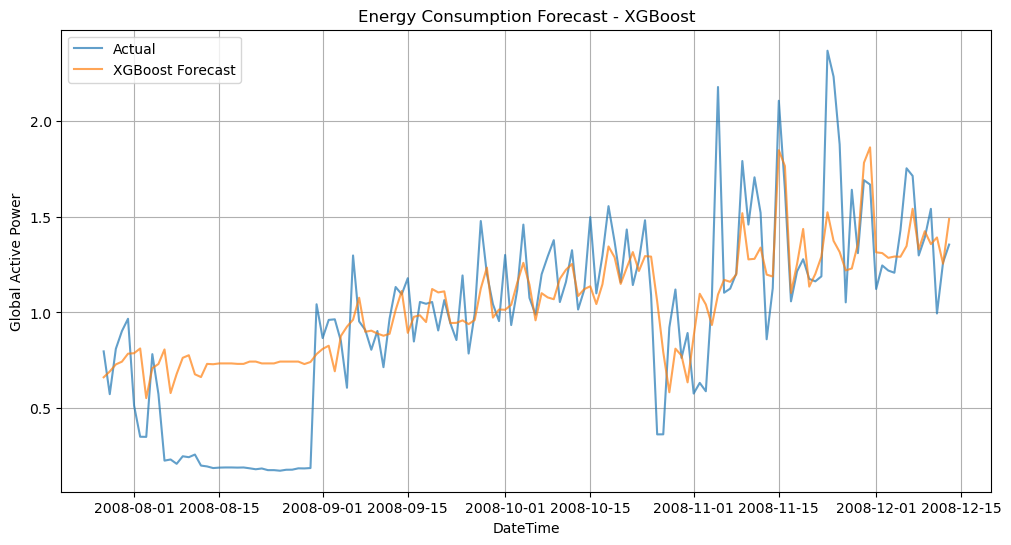

In [48]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', alpha=0.7)
plt.legend()
plt.title('Energy Consumption Forecast - XGBoost')
plt.xlabel('DateTime')
plt.ylabel('Global Active Power')
plt.grid(True)
plt.show()


## *Models Evaluation*

In [49]:
# Define a function for evaluating all three models
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mse, rmse

In [50]:
# Evaluate the ARIMA forecasts using the evaluation function
mae_arima, mse_arima, rmse_arima = evaluate_forecast(test, ARIMA_forecast)

In [51]:
# Evaluate the Prophet forecasts using the evaluation function
PROPHET_forecast1 = PROPHET_forecast.set_index('ds').loc[test.index]['yhat']
mae_prophet, mse_prophet, rmse_prophet = evaluate_forecast(test, PROPHET_forecast1)

In [52]:
# Evaluate the XGBoost forecasts using the evaluation function
mae_xgb, mse_xgb, rmse_xgb = evaluate_forecast(y_test, y_pred)

In [53]:
# Display the evaluation results for the models
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'MSE': [mse_arima, mse_prophet, mse_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})
print(results)

     Model       MAE       MSE      RMSE
0    ARIMA  0.223561  0.099950  0.316149
1  Prophet  0.240034  0.106026  0.325616
2  XGBoost  0.245355  0.105378  0.324620


## *Plotting Actual vs Forecasted*

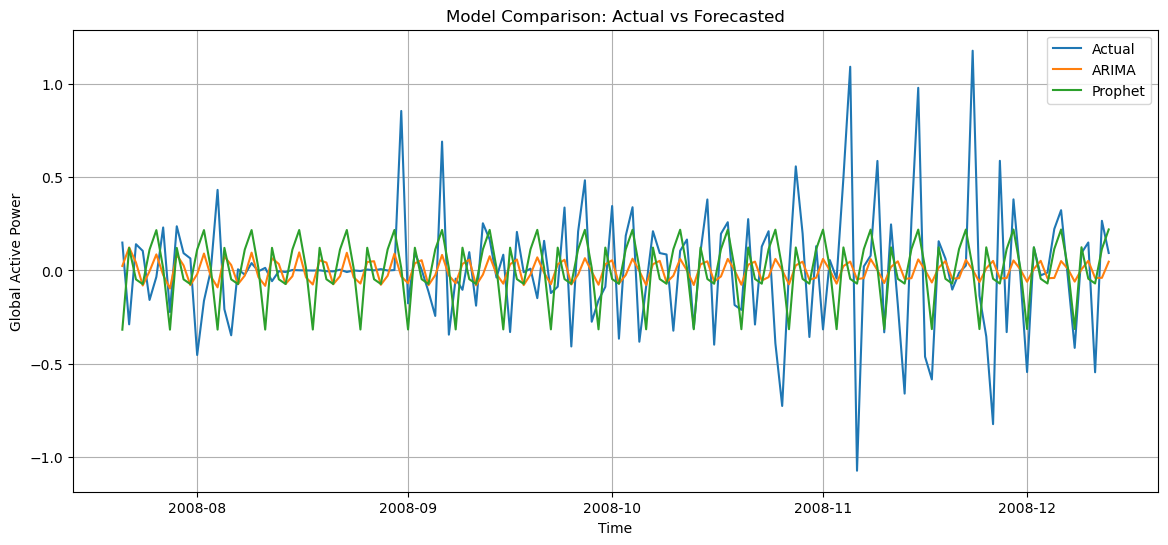

In [54]:
# Plot actual vs forecasted values for ARIMA and Prophet models
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, ARIMA_forecast, label='ARIMA')
plt.plot(test.index, PROPHET_forecast1, label='Prophet')
plt.legend()
plt.title("Model Comparison: Actual vs Forecasted")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()

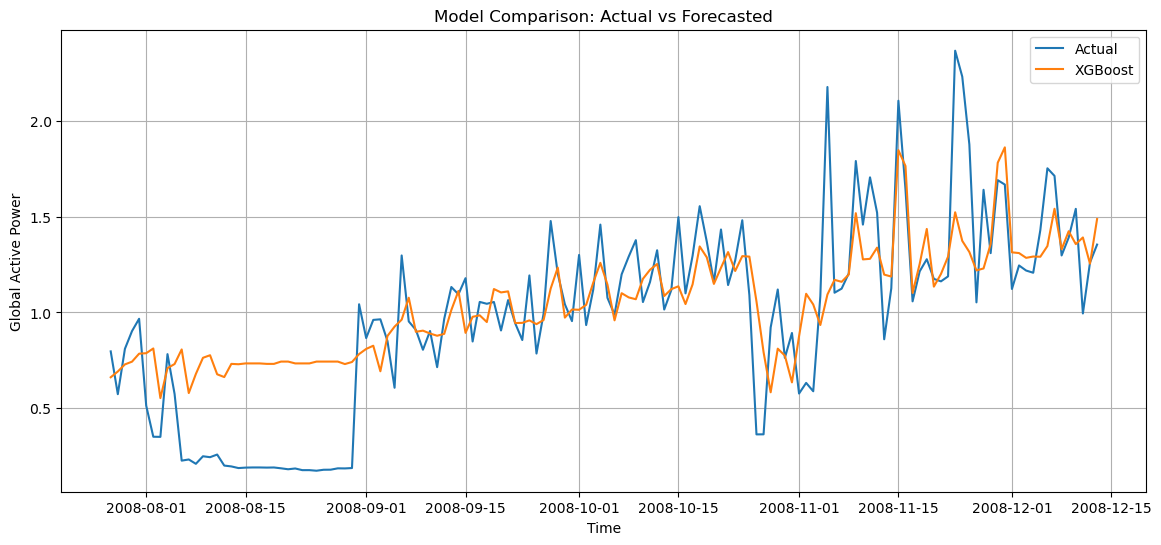

In [55]:
# Plot actual vs forecasted for XGBoost model
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='XGBoost')
plt.legend()
plt.title("Model Comparison: Actual vs Forecasted")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()

# *Conclusion*

<p style='font-size:20px;'><i>This project aimed to forecast short-term household energy consumption using three different models: ARIMA, Prophet, and XGBoost. After thorough preprocessing, feature engineering, and model evaluation, we arrive at the following insights:</i></p>
<ul style='font-size:20px;'><i>
<li>ARIMA is the best-performing model for this task based on RMSE = 0.316, making it the preferred choice for short-term daily energy consumption forecasting in this dataset.</li>
<li>However, for long-term deployments with evolving seasonality and user behavior patterns, XGBoost or Prophet may offer better adaptability and flexibility with retraining.</li>
<li>Feature engineering (lags, rolling means, date parts) significantly enhanced XGBoost performance, making it a viable alternative.</li>
<li>Prophet handled seasonality decomposition well, and its interpretability is a strength, though its accuracy lagged slightly.</li>
</i></ul>
